In [1]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'notebook' 
import warnings
warnings.filterwarnings("ignore")

In [2]:
Healthcare=pd.read_csv("healthcare-dataset-stroke-data.csv")
Healthcare.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
Healthcare.shape

(5110, 12)

In [4]:
Healthcare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


MetaData

Dataset Name: Stroke Prediction Dataset

Description: This dataset contains information on individuals' health factors, including medical conditions, lifestyle habits, and demographics, to predict the likelihood of a stroke occurrence.

Data Columns:

id (int64): Unique identifier for each record. 
gender (object): Gender of the individual (e.g., "Male", "Female").  
age (float64): Age of the individual in years.  
hypertension (int64): Whether the individual has hypertension (1 = Yes, 0 = No).  
heart_disease (int64): Whether the individual has heart disease (1 = Yes, 0 = No).  
ever_married (object): Marital status ("Yes", "No").  
work_type (object): The type of work the individual does ("Private", "Self-employed", "Govt_job", "children", "Never_worked").  
Residence_type (object): Type of area where the individual resides ("Urban", "Rural").  
avg_glucose_level (float64): Average glucose level in the blood.  
bmi (float64): Body Mass Index (BMI). Some values may be missing (4910 non-null entries).  
smoking_status (object): Smoking status ("formerly smoked", "Never smoked", "Smokes", "Unknown").  
stroke (int64): Target variable indicating whether the individual had a stroke (1 = Yes, 0 = No).

In [5]:
np.sum(Healthcare.duplicated())

np.int64(0)

There is no any duplicated.

Handling Missing Values

In [6]:
np.sum(Healthcare.isnull())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Result: There is no any missing value in dataset except bmi, so we just need to handle missing values in bmi.

In [7]:
missing_percentage = Healthcare['bmi'].isnull().mean() * 100
print(f"Percentage of missing values in '{'bmi'}': {missing_percentage:.2f}%")

Percentage of missing values in 'bmi': 3.93%


In [8]:
Healthcare.bmi.mean(),Healthcare.bmi.median()

(np.float64(28.893236911794666), np.float64(28.1))

<Axes: ylabel='Frequency'>

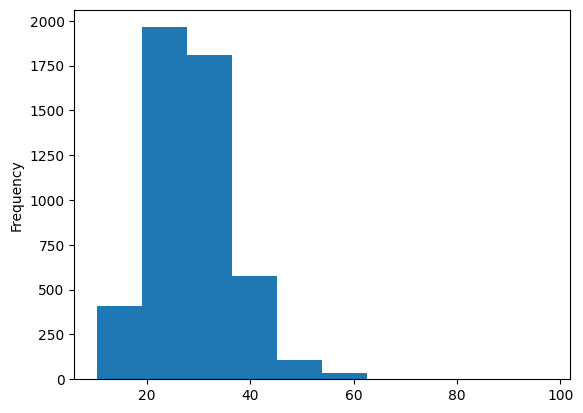

In [9]:
Healthcare['bmi'].plot(kind="hist")

<Axes: >

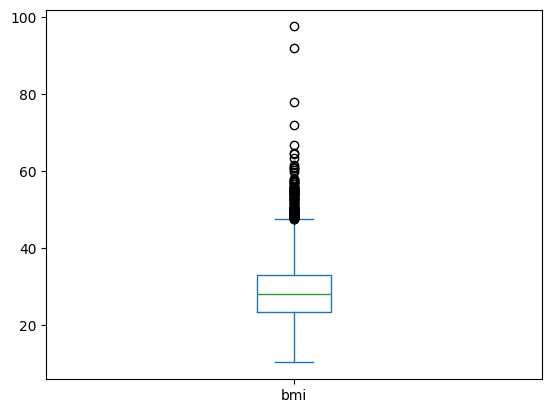

In [10]:
Healthcare['bmi'].plot(kind="box")

In [11]:
Healthcare['bmi'].fillna(Healthcare['bmi'].median(),inplace=True)
Healthcare.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Insight: According to the charts, which are skewed to the right, it seems that placing the missing values with the median is a suitable solution for handling the missing values.

In [12]:
np.sum(Healthcare.isnull())

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Handling Outliers

Handling Outliers

In [13]:
numeric_Healthcare = Healthcare.select_dtypes(include=['float64'])

In [14]:
Q1 = numeric_Healthcare.quantile(0.25)
Q3 = numeric_Healthcare.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = (numeric_Healthcare < lower_bound) | (numeric_Healthcare > upper_bound)
outliers_count = outliers.sum()
print(outliers_count)

age                    0
avg_glucose_level    627
bmi                  126
dtype: int64


Result: We have outliers in two variables include Average Glucose Lavel and BMI, so we invastige more these features to handle outliers. The approach is to fit the outliers with the mean.

In [15]:
def ImputeOutliersIQR(dataframeVariable):
    Q1 = dataframeVariable.quantile(0.25)
    Q3 = dataframeVariable.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataframeVariable = np.where(
        dataframeVariable >= upper_bound,
        dataframeVariable.mean(),
        np.where(
            dataframeVariable <= lower_bound,
            dataframeVariable.mean(),
            dataframeVariable
        )
    )
    return dataframeVariable


In [16]:
HealthcareWithoutOutliersavg_glucose_level = Healthcare.copy()

fig = make_subplots(
    rows=1, cols=5,
    specs=[[{}, {}, {} ,{} ,{}]], subplot_titles=("Initial Data","Step 1","Without Outliers"))
fig.add_trace(go.Box(y=HealthcareWithoutOutliersavg_glucose_level['avg_glucose_level'],  name="avg_glucose_level",marker_color='dodgerblue'), 1, 1)

HealthcareWithoutOutliersavg_glucose_level['avg_glucose_level'] = ImputeOutliersIQR(HealthcareWithoutOutliersavg_glucose_level['avg_glucose_level'])       
fig.add_trace(go.Box(y=HealthcareWithoutOutliersavg_glucose_level['avg_glucose_level'], name="avg_glucose_level",marker_color='royalblue'), 1, 2)

HealthcareWithoutOutliersavg_glucose_level['avg_glucose_level'] = ImputeOutliersIQR(HealthcareWithoutOutliersavg_glucose_level['avg_glucose_level'])        
fig.add_trace(go.Box(y=HealthcareWithoutOutliersavg_glucose_level['avg_glucose_level'], name="avg_glucose_level",marker_color='navy'), 1, 3)

fig.update_layout(height=700, width=1300, showlegend=False, title_text="REMOVE OUTLIERS FROM INCOME($)", 
                  title_font = {"size": 20, "color": 'gray', 'family':'Arial Black'}, title={ 'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show(renderer="iframe")

In [17]:
HealthcareWithoutOutliersbmi = HealthcareWithoutOutliersavg_glucose_level.copy()

fig = make_subplots(
    rows=1, cols=5,
    specs=[[{}, {}, {}, {}, {}]], subplot_titles=("Initial Data","Step 1","Step 2","Step 3","Without Outliers"))
fig.add_trace(go.Box(y=Healthcare['bmi'],  name="bmi",marker_color='lightblue'), 1, 1)

HealthcareWithoutOutliersbmi['bmi'] = ImputeOutliersIQR(HealthcareWithoutOutliersbmi['bmi'])        
fig.add_trace(go.Box(y=HealthcareWithoutOutliersbmi['bmi'], name="bmi",marker_color='cornflowerblue'), 1, 2)

HealthcareWithoutOutliersbmi['bmi'] = ImputeOutliersIQR(HealthcareWithoutOutliersbmi['bmi'])       
fig.add_trace(go.Box(y=HealthcareWithoutOutliersbmi['bmi'], name="bmi",marker_color='dodgerblue'), 1, 3)

HealthcareWithoutOutliersbmi['bmi'] = ImputeOutliersIQR(HealthcareWithoutOutliersbmi['bmi'])    
fig.add_trace(go.Box(y=HealthcareWithoutOutliersbmi['bmi'], name="bmi",marker_color='royalblue'), 1, 4)

HealthcareWithoutOutliersbmi['bmi']= ImputeOutliersIQR(HealthcareWithoutOutliersbmi['bmi'])      
fig.add_trace(go.Box(y=HealthcareWithoutOutliersbmi['bmi'], name="bmi",marker_color='navy'), 1, 5)

fig.update_layout(height=700, width=1300, showlegend=False, title_text="REMOVE OUTLIERS FROM bmi($)", 
                  title_font = {"size": 20, "color": 'gray', 'family':'Arial Black'}, title={ 'x':0.5,'xanchor': 'center','yanchor': 'top'})
fig.show(renderer="iframe")

Descriptive Statistics

In [18]:
Healthcare['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [19]:
Healthcare['age'].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

In [20]:
Healthcare['hypertension'].value_counts()

hypertension
0    4612
1     498
Name: count, dtype: int64

In [21]:
Healthcare['heart_disease'].value_counts()

heart_disease
0    4834
1     276
Name: count, dtype: int64

In [22]:
Healthcare['ever_married'].value_counts()

ever_married
Yes    3353
No     1757
Name: count, dtype: int64

In [23]:
Healthcare['work_type'].value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [24]:
Healthcare['Residence_type'].value_counts()

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64

In [25]:
Healthcare['avg_glucose_level'].describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

In [26]:
Healthcare['bmi'].describe()

count    5110.000000
mean       28.862035
std         7.699562
min        10.300000
25%        23.800000
50%        28.100000
75%        32.800000
max        97.600000
Name: bmi, dtype: float64

In [27]:
Healthcare['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

Encoding Categorical Variables

In [28]:
Healthcare.drop("id",axis=1,inplace=True)

In [29]:
Healthcare['gender']=Healthcare['gender'].apply(lambda x: 0 if x=="Male" else(1 if x=="Female" else 2))

In [30]:
Healthcare['ever_married']=Healthcare['ever_married'].apply(lambda x: 0 if x=="No" else 1)

In [31]:
Healthcare['Residence_type']=Healthcare['Residence_type'].apply(lambda x: 0 if x=="Urban" else 1)

In [32]:
Healthcare_encoded=pd.get_dummies(Healthcare,columns=["work_type","smoking_status"],drop_first=True)

In [33]:
Healthcare_encoded.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,67.0,0,1,1,0,228.69,36.6,1,False,True,False,False,True,False,False
1,1,61.0,0,0,1,1,202.21,28.1,1,False,False,True,False,False,True,False
2,0,80.0,0,1,1,1,105.92,32.5,1,False,True,False,False,False,True,False
3,1,49.0,0,0,1,0,171.23,34.4,1,False,True,False,False,False,False,True
4,1,79.0,1,0,1,1,174.12,24.0,1,False,False,True,False,False,True,False
